# ADTA 5900.701: CNN on CIFAR-10: Final Project

## PART III: Build, Train, and Test CNN on CIFAR-10 Dataset

## Set Path for Data Folder

In [1]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

## Load Data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [4]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [5]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [6]:
data_batch1.keys()

dict_keys([b'labels', b'data', b'batch_label', b'filenames'])

The batch files contain a dictionary with the following elements:

data: a 10000×3072 numpy array of uint8s. Each row of the array stores a 32×32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

## Display several examples of single images using matplotlib 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [8]:
X = data_batch1[b"data"] 

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [10]:
X[0].max()

255

In [11]:
(X[0]/255).max()

1.0

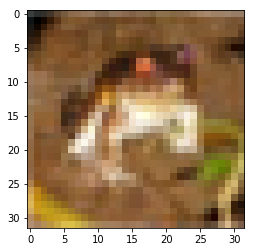

In [12]:
plt.imshow(X[0])

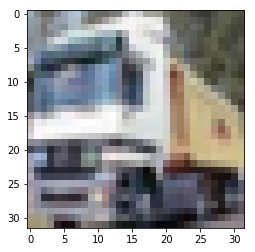

In [13]:
plt.imshow(X[1])

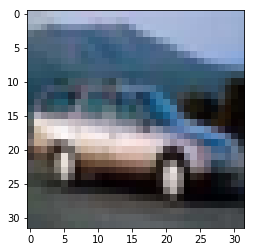

In [14]:
plt.imshow(X[4])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [15]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Define Supporting Functions to Build, Train, and Test CNN Model

#### Initialize Weights in Filter

In [16]:
# This function returns a tf.Variable used to store weights in a filter
# This variable is initialized with values that can be used to initialize weights
# The values are random numbers

def initialize_weights(filter_shape):
    init_random_dist =tf.truncated_normal(filter_shape, stddev=0.1)
    return (tf.Variable(init_random_dist) )

#### Initialize Bias

In [17]:
# This function returns a tf.Variable used to store bias
# This variable is initialized with values that can be used to initialize bias
# The value is initialized to 0.1

def initialize_bias(bias_shape):
    init_bias_vals =tf.constant(0.1, shape=bias_shape)
    return (tf.Variable(init_bias_vals) )

#### Setup Convolutional Layer and Perform Convolution Computation : Dot Product (x * W)

In [18]:
# Define a function to setup a convolutional layer (conv 2d)
# Parameters:
# ..) Inputs : [batch, H, W, Channels]
#..) filter_shape:
#[filter H, filter W, in_channels(in_depth=in_num_filters),out_channels(out_depth=out_num_filters)]
# for example : [5,5,1,32]
# Return : Outputs of the layer:The dot_product(inputs, filter_shape):

def create_convolution_layer_and_compute_dot_product(inputs,filter_shape):
    filter_initialized_with_weights= initialize_weights(filter_shape)
    conv_layer_outputs=tf.nn.conv2d(inputs,filter_initialized_with_weights,strides=[1,1,1,1],padding='SAME')
    return(conv_layer_outputs)

#### Setup a ReLU Layer and Perform Computation : Dot Product + Bias (x .W+b)

In [19]:
# Define a function
#..) First,  to setup a reLU layer: an activation function layer
#..) Then, perform the computation : dot product +bias (x * w) +b
# ReLU : Rectified Linear Unit - a popular activation function in CNN
# In this layer, the bias has been initialized

# Parameters:
# ..) Inputs : Outputs from the preceding convolution layer : Dot product inputs*weights
# ..) filter_shape
#[filter H, filter W, in_channels(in_depth=in_num_filters),out_channels(out_depth=out_num_filters)]
# for example : [5,5,1,32]
# Return : Outputs of the layer: dot product +b : (x *W)+ b


def create_relu_layer_and_compute_dot_product_plus_b(inputs,filter_shape):
    b=initialize_bias( [filter_shape[3] ])
    relu_layer_outputs=tf.nn.relu(inputs + b)
    return(relu_layer_outputs)

#### Setup a Pooling Layer and Reduce Spatial Size

In [20]:
# Define a function
#..) First,  to create a pooling layer
#..) Then, to reduce the spatial size of the inputs data

# Pooling Method : Max Pooling
# Kernel size : 2 X 2
# Stride : 2

# Parameters:
# ..) Inputs : Outputs from the preceding layer 
# ..) Return : Outputs of the layer

def create_maxpool2by2_and_reduce_spatial_size(inputs):
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return(pooling_layer_outputs)
                                    

#### Setup Fully Connected Layer and Perform Computation:(inputs * Weights) +Bias

In [21]:
# Define a function to set up a fully connected layer
# Also perform computation: (Dot Product (inputs*weights))+ bias
# Return the results
# Parameters:
#..) inputs:  Outputs of the preceding layer
#..) size: The size of the outputs, t.e. number of out_channels

def create_fully_connected_layer_and_compute_dotproduct_plus_bias (inputs, output_size):
    input_size = int(inputs.get_shape() [1] )
    W = initialize_weights([input_size, output_size ] )
    b = initialize_bias ([output_size])
    fc_xW_plus_bias_outputs = tf.matmul(inputs, W) + b
    return(fc_xW_plus_bias_outputs)

# PHASE I: Build Convolutional Neural Network

In [22]:
import tensorflow as tf

## Create Placeholders for Inputs and Labels: x and y_true

In [23]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [24]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [47]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        ## Grabbing all the data batches
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        ## Initializing empty variables
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
         # Stacking training images vertically
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshaping and normalizing of training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        
        # Encoding the training labels
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Stacking test images vertically
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshaping and normalizing of test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        
         # Encoding the test labels
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y


## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

#### DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

## Create 1st Convolution Layer and so on .............

In [30]:
# Create the 1st convolution layer
# 2D data size : 32 * 32
# Inputs: x, 32*32*3 ( 3 in_channels)
# Output shape: 32*32*32(Depth =32 out-channels)
# Filter size = 4*4
# filter _shape : weight shape[4,4,3,32]
# stride = 1
# stride shape : [1,1,1,1]
# Padding = SAME


# Create the 1st convolution layer
# Then learn/extract the features, get the results (outputs) : Dot product of inputs*weights
# Return the outputs of the layer

conv_layer_1_outputs \
  =create_convolution_layer_and_compute_dot_product(x,filter_shape=[4,4,3,32])

#### Create the ReLU layer for the 1st convolution layer

In [31]:
# Accept the outputs from the 1st conv layer as the inputs
# Perform the computation at the layer : add inputs+ bias
# Return the outputs of the layer

conv_relu_layer_1_outputs \
  =create_relu_layer_and_compute_dot_product_plus_b(conv_layer_1_outputs,filter_shape=[4,4,3,32])


#### Create 1st Pooling Layer and reduce spatial size

In [32]:
# Create the 1st pooling layer
# Then reduce the spatial size of the input data
# Return : Outputs of the layer
pooling_layer_1_outputs=create_maxpool2by2_and_reduce_spatial_size(conv_relu_layer_1_outputs)

#### Create 2nd Convolutional layer, ReLU layer, and perform computation : x * w+ b

In [33]:
# Create the 2nd convolution layer
# 2D data size : 16 * 16
# Input shape: 16*16*32 ( 32 in_channels)
# Output shape: 16*16*64(Depth =64 out-channels)
# Filter size = 4*4
# filter _shape : weight shape[4,4,32,64]
# stride = 1
# stride shape : [1,1,1,1]
# Padding = SAME

# Create the 2nd convolution layer
# Then learn/extract the features, get the results (outputs) : Dot product of inputs*weights
# Return the outputs of the layer

conv_layer_2_outputs \
  =create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs,filter_shape=[4,4,32,64])

#### Create the ReLU layer for the 2nd convolution layer

In [34]:
# Accept the outputs from the 2nd conv layer as the inputs
# Perform the computation at the layer : add inputs+ bias
# Return the outputs of the layer

conv_relu_layer_2_outputs \
  =create_relu_layer_and_compute_dot_product_plus_b(conv_layer_2_outputs,filter_shape=[4,4,32,64])

#### Create 2nd Pooling Layer and reduce spatial size

In [35]:
# Create the 2nd pooling layer
# Then reduce the spatial size of the input data
# Return : Outputs of the layer

pooling_layer_2_outputs=create_maxpool2by2_and_reduce_spatial_size(conv_relu_layer_2_outputs)

#### Reshape/Flatten Data Making it Ready to be Def into 1st FC layer

In [36]:
# Reshape and flatten the output of the 2nd pooling layer
# Prepare to feed the output data into the 1st fully connected layer

pooling_layer_2_outputs_flat=tf.reshape(pooling_layer_2_outputs,[-1, 8*8*64])

#### Create 1st FC Layer, ReLU Layer, and output Data to Dropout Layer

In [37]:
# First create  the FC (Fully Connected ) layer
# Feed the output(already flattened ) of the 2nd pooling layer as the inputs into this layer
# Then perform the computation : dot product _bias ( x *W) + b

# Parameters:
# ..) pooling_layer_2_outputs_flat
# ..) output_size: 1024 out channels

# Return: Outputs of the computation (x*W)_b

fc_layer_1_outputs \
=create_fully_connected_layer_and_compute_dotproduct_plus_bias(pooling_layer_2_outputs_flat,
output_size =1024)

# Return: Outputs of the layer
fc_relu_layer_1_outputs=tf.nn.relu(fc_layer_1_outputs)

#### Create Dropout Layer and Dropout of Outputs Randomly

In [38]:
# Declare a placeholder to hold the value of probability (percentage x) to keep:
# i.e. the % of total output channels that will be kept
# e.g. keep_prob=hold_prob= 50% —> keep 50 %..> Dropout 50%
# which nodes/channels to keep or dropout : selected randomly

hold_prob= tf.placeholder (tf.float32)

# Dropout
# set the outputs to 0 (zero) so that they will be ignored in the next layer

fc_dropouts_outputs=tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)


#### Create Final FC Layer, Compute (x.W_b) and produce final outputs

In [39]:
# Create the final FC layer
# Then compute: x*W_b
# parameters:
# ..) fc_dropouts_outputs : Outputs from the dropout  layer
# ..)

# Return y_pred: final predicted outputs, I.e., final classification outputs

y_pred = create_fully_connected_layer_and_compute_dotproduct_plus_bias(fc_dropouts_outputs,output_size=10)

#### Define Loss Function and Calculate Softmax Cross Entropy Loss

In [40]:
# Define loss function :cross-entropy with logins . i.e. with the final outputs
# Calculate the softmax entropy loss


softmax_cross_entropy_loss=tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

# Compute the means of losses

cross_entropy_mean = tf.reduce_mean(softmax_cross_entropy_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### Create an Optimizer to Optimize CNN Model and set learning rate

In [41]:
# Get an ADAM optimizer

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

#### Create a Trainer to Train CNN Model



In [42]:
cnn_trainer = optimizer.minimize (cross_entropy_mean)

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

#### Create a variable initializer to initialize All Variables

In [48]:
# Get a variable initializer

vars_initializer = tf.global_variables_initializer()

In [49]:
# x: 50000 images
# Each time of training (run the whole process ) = 1 step
# Each step, i.e., each time of training : Use one batch of inputs
# batch size = 100 images —> Total number of batches : 50000/100 = 500 batches
# steps = 10000: Finish the training after running 10000 times

steps = 10000


## Set up image data: Calling CifarHelper.set_up_images()

In [50]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()


Setting Up Training Images and Labels
Setting Up Test Images and Labels


#### Run tf.Session () to Train and test Deep Learning CNN Model

In [51]:
with tf. Session () as sess:
    
    
    # First, run vars_initializer to initialize all variables
    sess.run(vars_initializer)
    
    for i in range (steps):
        
        
        # Each batch: 100 images
        batch =ch.next_batch(100)
    
        
        # Train the model cnn_trainer
        # Dropout keep_prob (% to keep) : 0.5 ..> 50% will be dropped out 
        
        sess.run(cnn_trainer, feed_dict={x:batch[0], y_true:batch[1], hold_prob :0.5})
        
        # Test the model: at each 100th step
        # Run this block of code for each 100 times of training, each time run a batch
        if i % 100 == 0:
            
            print('ON STEP: {}'.format(i) )
            print('ACCURACY: ')
            
            # Compare to find matches of y_pred and y_true
            matches =tf.equal( tf.argmax(y_pred,1 ), tf.argmax(y_true,1) )
            
            
            # Cast the matches from integers to tf.float32
           # Calculate the accuracy using the mean of matches
        
            acc=tf.reduce_mean(tf.cast(matches,tf.float32) )
            
           # Test the model at each 100th step
           # Using the test dataset
           # Dropout: NONE because of test, not training
    
            
            print(sess.run(acc, feed_dict = {x:ch.test_images ,y_true :ch.test_labels, \
                                                                 hold_prob: 1.0} ) )
           
            print('\n')
            
        
           


ON STEP: 0
ACCURACY: 
0.1261


ON STEP: 100
ACCURACY: 
0.3954


ON STEP: 200
ACCURACY: 
0.4496


ON STEP: 300
ACCURACY: 
0.4898


ON STEP: 400
ACCURACY: 
0.5055


ON STEP: 500
ACCURACY: 
0.5363


ON STEP: 600
ACCURACY: 
0.5565


ON STEP: 700
ACCURACY: 
0.5578


ON STEP: 800
ACCURACY: 
0.5718


ON STEP: 900
ACCURACY: 
0.5756


ON STEP: 1000
ACCURACY: 
0.5892


ON STEP: 1100
ACCURACY: 
0.6106


ON STEP: 1200
ACCURACY: 
0.5963


ON STEP: 1300
ACCURACY: 
0.622


ON STEP: 1400
ACCURACY: 
0.6178


ON STEP: 1500
ACCURACY: 
0.6262


ON STEP: 1600
ACCURACY: 
0.6361


ON STEP: 1700
ACCURACY: 
0.6494


ON STEP: 1800
ACCURACY: 
0.6481


ON STEP: 1900
ACCURACY: 
0.6522


ON STEP: 2000
ACCURACY: 
0.6618


ON STEP: 2100
ACCURACY: 
0.6665


ON STEP: 2200
ACCURACY: 
0.6689


ON STEP: 2300
ACCURACY: 
0.6547


ON STEP: 2400
ACCURACY: 
0.664


ON STEP: 2500
ACCURACY: 
0.6635


ON STEP: 2600
ACCURACY: 
0.6643


ON STEP: 2700
ACCURACY: 
0.6695


ON STEP: 2800
ACCURACY: 
0.6686


ON STEP: 2900
ACCURACY: 
0.6